In [ ]:
import os
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

## Image classification


We download the dataset from
https://chaladze.com/l5/img/Linnaeus%205%2032X32.rar
and uncompress the .rar dataset to a folder named "Linnaeus_5_32X32" in the current directory.
This folder contains a subfolder "Linnaeus 5 32X32", which contains a test and a train folder with the images of the dataset in 5 different classes: berry, bird, dog, flower, other.

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
!apt-get install unrar
!pip install rarfile

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
unrar is already the newest version (1:6.1.5-1ubuntu0.1).
0 upgraded, 0 newly installed, 0 to remove and 29 not upgraded.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
print("WD:", os.getcwd())

WD: /content/drive/My Drive/Colab Notebooks


In [ ]:
os.chdir("/content/drive/My Drive/Colab Notebooks")
print("WD:", os.getcwd())

WD: /content/drive/My Drive/Colab Notebooks


In [ ]:
rar_path = "/content/drive/My Drive/Colab Notebooks/Linnaeus532X32.rar"
extract_path = "/content/drive/My Drive/Colab Notebooks/Linnaeus_5_32X32"

In [ ]:
import rarfile
import os

with rarfile.RarFile(rar_path, 'r') as rf:
    rf.extractall(extract_path)

print(f"data extracted: {extract_path}")

data extracted: /content/drive/My Drive/Colab Notebooks/Linnaeus_5_32X32


In [ ]:
# Much faster, was having issues before using RAM

!cp -r Linnaeus_5_32X32 /dev/shm/

In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 128

trainset = torchvision.datasets.ImageFolder(root="/dev/shm/Linnaeus_5_32X32/Linnaeus 5 32X32/train", transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)

testset = torchvision.datasets.ImageFolder(root="/dev/shm/Linnaeus_5_32X32/Linnaeus 5 32X32/test", transform=transform)

testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)

classes = ('berry', 'bird', 'dog', 'flower', 'other')

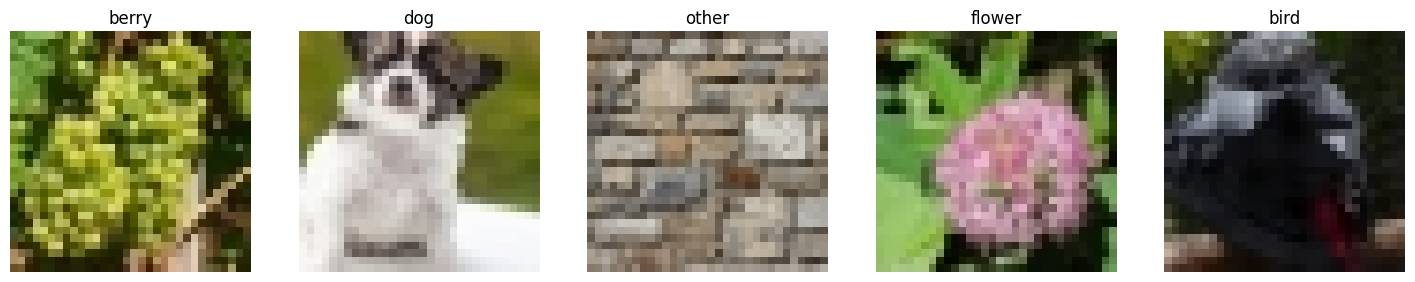

In [ ]:
# We want to store 1 image from every class, so we initialise like so

images = {}

# Run a nested for loop through the dataset which collects and stores one image per
# class, breaking when we have an image from a given class on the inside level and
# breaking fully when we have an image from each class

for imgs, names in trainloader:

    for img, name in zip(imgs, names):

        if name.item() not in images:

            images[name.item()] = img

        if len(images) == len(classes):
            break

    if len(images) == len(classes):
        break

# Create a plot for the images

fig, axes = plt.subplots(1, len(classes), figsize=(18, 5))

for n, (name, img) in enumerate(images.items()):

# Remember the images are stored as tensors, so we convert them to numpy to
# visualise, and we undo the normalisation we did before

    img = img.permute(1, 2, 0).numpy()

    img = (img * 0.5) + 0.5

    axes[n].imshow(img)

    axes[n].set_title(classes[name])

    axes[n].axis("off")

plt.show()

We want to implement a convolutional neural network (CNN) in PyTorch that processes
32 × 32 RGB images through multiple convolutional and pooling layers, followed by fully connected
layers for classification into 5 categories. 

In [ ]:
class myCNN(nn.Module):

  def __init__(self):

    super().__init__()

    # Convolutional layers defined as required, with 3x3 kernel and padding = 1

    self.conv1 = nn.Conv2d(3, 32, 3, padding = 1)
    self.conv2 = nn.Conv2d(32, 64, 3, padding = 1)
    self.conv3 = nn.Conv2d(64, 128, 3, padding = 1)
    self.conv4 = nn.Conv2d(128, 128, 3, padding = 1)
    self.conv5 = nn.Conv2d(128, 256, 3, padding = 1)
    self.conv6 = nn.Conv2d(256, 256, 3, padding = 1)

    # Max pooling after every 2 conv layers...

    self.pool = nn.MaxPool2d(2, stride = 2)

    # Three fully connected layers, flatten output of convolutional layers,
    # i.e. 256 x 4 x 4 = 4096

    self.fc1 = nn.Linear(4096, 512)
    self.fc2 = nn.Linear(512, 64)
    self.fc3 = nn.Linear(64, 5)

  def forward(self, x):

    # ReLU activation on every layer except the output, pooling every 2 layers

    x = F.relu(self.conv1(x))
    x = F.relu(self.conv2(x))

    x = self.pool(x)

    x = F.relu(self.conv3(x))
    x = F.relu(self.conv4(x))

    x = self.pool(x)

    x = F.relu(self.conv5(x))
    x = F.relu(self.conv6(x))

    x = self.pool(x)

    x = torch.flatten(x, 1)

    # Flatten to map output of last convolutional layer to the first input
    # of the fully connected layer

    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))

    # Output layer provides raw logits

    x = self.fc3(x)

    return(x)

  def features(self, x):

    # Important for implementing fine-tuner, we need the input of that function
    # to be the (flattened) output of the last convolutional layer of myCNN

        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))

        x = self.pool(x)

        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))

        x = self.pool(x)

        x = F.relu(self.conv5(x))
        x = F.relu(self.conv6(x))
        x = self.pool(x)

        x = torch.flatten(x, start_dim=1)
        return x

In [ ]:
from torchsummary import summary

model = myCNN()

model.to(device)

summary(model, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
            Conv2d-2           [-1, 64, 32, 32]          18,496
         MaxPool2d-3           [-1, 64, 16, 16]               0
            Conv2d-4          [-1, 128, 16, 16]          73,856
            Conv2d-5          [-1, 128, 16, 16]         147,584
         MaxPool2d-6            [-1, 128, 8, 8]               0
            Conv2d-7            [-1, 256, 8, 8]         295,168
            Conv2d-8            [-1, 256, 8, 8]         590,080
         MaxPool2d-9            [-1, 256, 4, 4]               0
           Linear-10                  [-1, 512]       2,097,664
           Linear-11                   [-1, 64]          32,832
           Linear-12                    [-1, 5]             325
Total params: 3,256,901
Trainable params: 3,256,901
Non-trainable params: 0
---------------------------

We write a training function that takes the model, number of epochs, optimizer, criterion, and trainloader as input. The function
shoud loop over the batches in the trainloader, compute the loss function as criterion(outputs,
labels) and update the optimizer.

In [ ]:
def train(myCNN, nr_epochs, optimizer, criterion, trainloader):

  myCNN.to(device)

  for epoch in range(nr_epochs):

    for i, (images, labels) in enumerate(trainloader):

      # Want to make sure the images and the labels are in the same device as the model

      images, labels = images.to(device), labels.to(device)

      # Reset grad

      optimizer.zero_grad()

      # Forward pass

      outputs = myCNN(images)

      # Compute loss

      loss = criterion(outputs, labels)

      # Backpropogation

      loss.backward()

      # Update

      optimizer.step()

      # Add to loss

      # Print loss every 10 batches

      if (i + 1) % 10 == 0:
                print(f"epoch [{epoch+1}/{nr_epochs}], batch [{i+1}/{len(trainloader)}], loss: {loss.item() / 10:.4f}")

    print('Completed training')


In [ ]:
# Train using Adam

criterion_q6 = torch.nn.CrossEntropyLoss()
optimizer_q6 = torch.optim.Adam(model.parameters(), lr=0.001)

train(model, trainloader = trainloader, optimizer = optimizer_q6, criterion = criterion_q6, nr_epochs=30)

In [ ]:
def accuracy(model, testloader):

  model.to(device)

  # Obtain class names from dataset

  class_names = testloader.dataset.classes

  no_classes = len(class_names)

  # Initialise to keep track of the accurate and total images

  class_acc = torch.zeros(no_classes)
  class_total = torch.zeros(no_classes)

  # No need to calculate grad...

  with torch.no_grad():

    for images, labels in testloader:

      # Set device

      images, labels = images.to(device), labels.to(device)

      # Forward pass

      outputs = model(images)

      # Obtain predictions, can drop max values

      _, predicted = torch.max(outputs, 1)

      # Count number of accurate images in each class

      for i in range(len(labels)):

        # Count total images

        label = labels[i].item()
        class_total[label] += 1

        # Count accurate images

        if predicted[i] == label:
          class_acc[label] += 1

  for class_name, acc, total in zip(testloader.dataset.classes, class_acc, class_total):
    accuracy = 100 * acc / total if total > 0 else 0
    print(f"accuracy '{class_name}': {accuracy:.2f}%")

In [ ]:
accuracy(model,testloader)

accuracy 'berry': 66.00%
accuracy 'bird': 59.00%
accuracy 'dog': 66.00%
accuracy 'flower': 72.00%
accuracy 'other': 57.25%


## Fine-tuning a pretrained model

In [ ]:
import shutil

src = "Linnaeus_5_32X32"
dst = "Linnaeus_5_32X32_small"

if not os.path.exists(dst):
    shutil.copytree(src, dst)
    print("Folder copied")
else:
    print("Folder already exists")

Folder already exists


In [ ]:
small_dataset = "Linnaeus_5_32X32_small/Linnaeus 5 32X32"

# Want to keep...

small_classes = ["dog", "flower"]

# Want to remove...

for split in ["train", "test"]:

    folder_path = os.path.join(small_dataset,  split)

    for class_name in os.listdir(folder_path):

        class_path = os.path.join(folder_path, class_name)

        if class_name not in small_classes:

          # Delete subfolder if not dog or flower

            shutil.rmtree(class_path)

In [ ]:
!cp -r Linnaeus_5_32X32_small /dev/shm/

In [ ]:
# Load training and test sets as before

trainset_small = torchvision.datasets.ImageFolder(root="/dev/shm/Linnaeus_5_32X32_small/Linnaeus 5 32X32/train", transform=transform)

trainloader_small = torch.utils.data.DataLoader(trainset_small, batch_size=batch_size, shuffle=True)

testset_small = torchvision.datasets.ImageFolder(root="/dev/shm/Linnaeus_5_32X32_small/Linnaeus 5 32X32/test", transform=transform)

testloader_small = torch.utils.data.DataLoader(testset_small, batch_size=batch_size, shuffle=False)

In [ ]:
class myMLP(nn.Module):

  # Input size is the ouput of the last convolutional layer of myCNN - we take
  # the final feature map of myCNN and plug it in here to refine. Our output size
  # is of course 2, and hidden layers are of size 128

  def __init__(self, input_size = 4096, output_size = 2, hidden_size = 128):

     super().__init__()

     self.fc1 = nn.Linear(input_size, hidden_size)
     self.fc2 = nn.Linear(hidden_size, hidden_size)
     self.fc3 = nn.Linear(hidden_size, output_size)

  def forward(self, x):

    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))

    # NLLLoss documentation says "The input given through a forward call is
    # expected to contain log-probabilities of each class." It also says that
    # "Obtaining log-probabilities in a neural network is easily achieved by
    # adding a LogSoftmax layer in the last layer of your network". Also, it states 
    # that the LogSoftmax operator is the generalisation of the sigmoid function,
    # which is used for log-probabilities. We make sure to normalise within classes.

    x = F.log_softmax(self.fc3(x), dim = 1)

    return x

   # This is a good choice for this task as it converts raw outputs into meaningful
   # probabilities of each image belonging to its class. It also means that for high
   # probabilities the loss is low, and for lower probabilities the loss is higher
   #Applying LogSoftmax before NLLLoss also helps avoid underflow.


In [ ]:
refined_model = myMLP()

refined_model.to(device)

summary(refined_model, input_size = (4096,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 128]         524,416
            Linear-2                  [-1, 128]          16,512
            Linear-3                    [-1, 2]             258
Total params: 541,186
Trainable params: 541,186
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.02
Forward/backward pass size (MB): 0.00
Params size (MB): 2.06
Estimated Total Size (MB): 2.08
----------------------------------------------------------------


In [ ]:
def fine_tune(myCNN, myMLP, nr_epochs, optimizer, criterion, trainloader):

  myCNN.to(device)
  myMLP.to(device)

  for param in myMLP.parameters():
        param.requires_grad = True

  for epoch in range(nr_epochs):

    for i, (images, labels) in enumerate(trainloader_small):

      # Want to make sure the images and the labels are in the same device as the model

      images, labels = images.to(device), labels.to(device)

      # Obtain output of myCNN's last layer of features , i.e. input of myMLP

      with torch.no_grad():

        features = myCNN.features(images)

     # Forward pass

      outputs = myMLP(features)

      loss = criterion(outputs, labels)

      # Reset grad

      optimizer.zero_grad()

      # Backpropogation

      loss.backward()

      # Update

      optimizer.step()

      # Print loss every 10 epochs

      if (i + 1) % 10 == 0:
                print(f"epoch [{epoch+1}/{nr_epochs}], batch [{i+1}/{len(trainloader)}], loss: {loss.item() / 10:.10f}")

    print('Finished Training')


In [ ]:
criterion_q4 = torch.nn.NLLLoss()
optimizer_q4 = torch.optim.Adam(refined_model.parameters(), lr=0.001)


fine_tune(model, refined_model, trainloader = trainloader_small, optimizer = optimizer_q4, criterion = criterion_q4, nr_epochs=30)

epoch [1/30], batch [10/19], loss: 0.0034205537
Finished Training
epoch [2/30], batch [10/19], loss: 0.0060093202
Finished Training
epoch [3/30], batch [10/19], loss: 0.0005982177
Finished Training
epoch [4/30], batch [10/19], loss: 0.0007500428
Finished Training
epoch [5/30], batch [10/19], loss: 0.0005127787
Finished Training
epoch [6/30], batch [10/19], loss: 0.0000600050
Finished Training
epoch [7/30], batch [10/19], loss: 0.0000590270
Finished Training
epoch [8/30], batch [10/19], loss: 0.0000453284
Finished Training
epoch [9/30], batch [10/19], loss: 0.0000223022
Finished Training
epoch [10/30], batch [10/19], loss: 0.0000340772
Finished Training
epoch [11/30], batch [10/19], loss: 0.0000091876
Finished Training
epoch [12/30], batch [10/19], loss: 0.0000154067
Finished Training
epoch [13/30], batch [10/19], loss: 0.0000274688
Finished Training
epoch [14/30], batch [10/19], loss: 0.0000108239
Finished Training
epoch [15/30], batch [10/19], loss: 0.0000075641
Finished Training
epoc

In [ ]:
def accuracy_fine_tune(myCNN, myMLP, testloader_small):

  myCNN.to(device)
  myMLP.to(device)

  # Obtain class names from dataset

  class_names = testloader_small.dataset.classes

  no_classes = len(class_names)

  # Initialise to keep track of the accurate and total images

  class_acc = torch.zeros(no_classes)
  class_total = torch.zeros(no_classes)

  # No need to calculate grad...

  with torch.no_grad():

    for images, labels in testloader_small:

      # Set device

      images, labels = images.to(device), labels.to(device)

      with torch.no_grad():

        features = myCNN.features(images)

      # Forward pass

      outputs = myMLP(features)

      # Obtain predictions, can drop max values

      _, predicted = torch.max(outputs, 1)

      # Count number of accurate images in each class

      for i in range(len(labels)):

        # Count total images

        label = labels[i].item()
        class_total[label] += 1

        # Count accurate images

        if predicted[i] == label:
          class_acc[label] += 1

  for class_name, acc, total in zip(testloader_small.dataset.classes, class_acc, class_total):
    accuracy = 100 * acc / total if total > 0 else 0
    print(f"accuracy '{class_name}': {accuracy:.2f}%")

In [ ]:
accuracy_fine_tune(model, refined_model, testloader_small)

accuracy 'dog': 96.25%
accuracy 'flower': 96.25%


The results are far better than those from the lone CNN model, the updated model is extremely reliable at classifying the images correctly. This is probably down to a range of factors: firstly, we were only classifying 2 categories using the fine-tuner, meaning it was a binary problem - much less complex than classifying into 5 categories, which, of course, naturally leads to higher accuracy. Secondly, this second model used the information from the convolutional layers of the initial network, meaning it wasn't learning from scratch like it was in the first case, and our fine-tuner was able to leverage this.


## Adversarial attacks

In [ ]:
def adversarial(myCNN, myMLP, image, label, epsilon):

  # Don't need to track grad for original

  image = image.to(device).clone().detach()
  label = label.to(device)

  # We want to track grad for clone

  image.requires_grad = True

  nr_steps = 10
  mu = 1.0

  # Definition of alpha and g_0 in algorithm 1

  alpha = epsilon / nr_steps

  g = torch.zeros_like(image)

  # Using negative log-likelihood

  criterion = torch.nn.NLLLoss()

  for i in range(nr_steps):

    # Run through CNN and add batch dimension

    image.requires_grad = True

    features = myCNN.features(image.unsqueeze(0))

    # Run through refiner

    outputs = myMLP(features)

    # Compute loss

    loss = criterion(outputs, label.unsqueeze(0))

    # Gradient

    loss.backward()

    # Normalise using L_1 to use in algorithm

    grad = image.grad.data
    grad_norm = grad / grad.abs().sum(dim = (0, 1, 2), keepdim = True)

    # Full update

    g = mu * g + grad_norm

    # Update image, restricting perturbations to epsilon bound in infinity norm

    perturbation = alpha * torch.sign(g)
    perturbation = torch.clamp(perturbation, -epsilon, epsilon)

    # Preserve gradient requirement by updating data

    image.data = torch.clamp(image + perturbation, 0, 1)

    # Reset grad

    image.grad.zero_()

  # Final forward pass

  output = myCNN.features(image.unsqueeze(0))
  output = myMLP(features)

  # We have log probabilites as the outputs of myMLP, so we exponentiate to
  # get the probabilities

  p = torch.exp(output)[0][label.item()].item()

  # We can remove image.detach() as we haven't reintroduced grad tracking at any
  # point, it is superfluous

  return image, p


In [ ]:
images, labels = next(iter(testloader_small))
images, labels = images.to(device), labels.to(device)

random_image = images[1]
random_label = labels[1]

In [ ]:
epsilon = 0.05

adv_image, prob_true_label = adversarial(model, refined_model, random_image, random_label, epsilon)

print(f"Success. p = {prob_true_label}")


Success. p = 0.46127331256866455


Successful attack


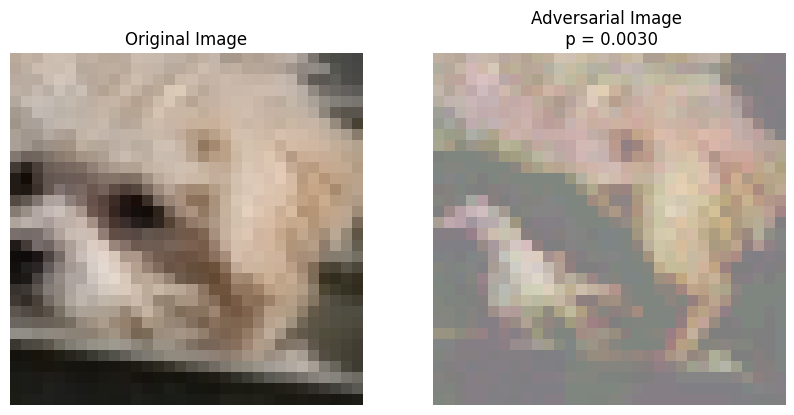

In [ ]:
successful_attack = False

for images, labels in testloader_small:

  images, labels = images.to(device), labels.to(device)

  # Obtain predictions

  with torch.no_grad():

    features = model.features(images)
    outputs = refined_model(features)
    _, predicted = torch.max(outputs, 1)

  # Look through for correctly classified dog images only

  for i in range(len(labels)):

    if labels[i] == 0 and predicted[i] == 0:

      original_image, true_label = images[i], labels[i]

        # Adversarial attack...

      image_adv, p_true = adversarial(model, refined_model, original_image, true_label, 0.05)

        # Break when attack is successful

      if p_true < 0.5:

          print("Successful attack")
          successful_attack = True

          # Move the CPU and detach

          og = original_image.cpu().detach().permute(1, 2, 0).numpy()
          adv = image_adv.cpu().detach().permute(1, 2, 0).numpy()

          # Undo normalisation

          og = (og * 0.5) + 0.5
          adv = (adv * 0.5) + 0.5

          fig, axes = plt.subplots(1, 2, figsize = (10, 5))

          axes[0].imshow(og)
          axes[0].set_title("Original Image")
          axes[0].axis("off")

          axes[1].imshow(adv)
          axes[1].set_title(f"Adversarial Image \n p = {p_true:.4f}")
          axes[1].axis("off")

          plt.show()

          break

  if successful_attack:
    break

In [ ]:
def accuracy_adversarial(myCNN, myMLP, testloader_small, epsilon):

  total_correct = 0
  total_attacked = 0

  for images, labels in testloader_small:

    images, labels = images.to(device), labels.to(device)

    with torch.no_grad():

      # Predictions

      features = myCNN.features(images)
      outputs = myMLP(features)

      _, predicted = torch.max(outputs, 1)

      # Loop over the images classified correctly in the current batch

    for i in range(len(labels)):

      if predicted[i] == labels[i]:

      # Update correctly classified total

        total_correct += 1

        adv_image, p_true = adversarial(myCNN, myMLP, images[i], labels[i], epsilon)

        # Update attacked total

        if p_true < 0.5:

          total_attacked += 1

  # Return success rate

  return total_attacked / total_correct

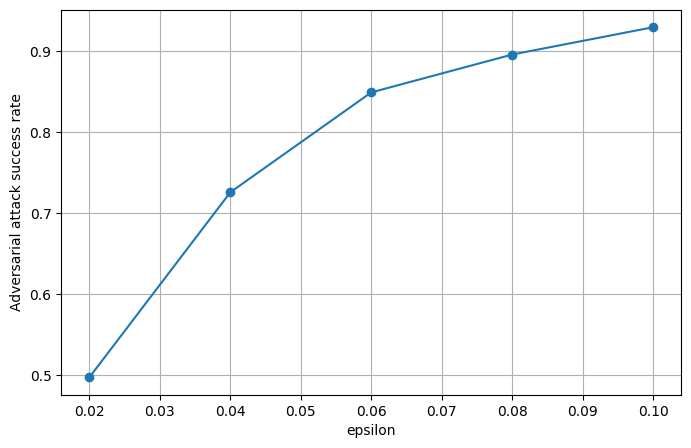

In [ ]:
# Initialise values and success rates

epsilons = [0.02, 0.04, 0.06, 0.08, 0.1]

success_rates = []

for epsilon in epsilons:

  # Store success rate for each epsilon

  success_rate = accuracy_adversarial(model, refined_model, testloader_small, epsilon)

  success_rates.append(success_rate)

# Plot

plt.figure(figsize=(8, 5))
plt.plot(epsilons, success_rates, marker='o', linestyle='-')
plt.xlabel("epsilon")
plt.ylabel("Adversarial attack success rate")
plt.grid(True)
plt.show()

We can see that increasing epsilon increases the adversarial attack success rate. This makes sense as bigger epsilon values lead to bigger perturbations, meaning we would expect "stronger" attacks for larger values of epsilon.

However, we can also see that there is a diminishing rate of increase in the success of the adversarial attacks for increasing epsilon. We can make sense of this by acknowledging the fact that this is a binary classification problem - each image is either "correctly" or "wrongly" classified, so at a certain point, it doesn't matter how strong the perturbation is -
once it is strong enough to make the image go from correctly to wrongly classified, increasing it won't change the success rate of the attack.

While it may be interesting to see how often we can get the model to misclassify for larger and larger epsilon, it has little relevance in real-world applications - we would obviously expect images which have large perturbations, and are therefore completely different from the original, to be misclassified. Attempting to make a model robust under these large perturbations can lead to overfitting.

It is more interesting to note the success rates for smaller step sizes - this highlights an interesting point about adversarial attacks, which is that even tiny, imperceptible changes can cause a model to misclassify an image very often - even at the low end, images are misclassified >40% of the time.This is much more relevant to real-life instances of adversarial attacks, where adversarial attacks are usually subtle and not visible to the human eye. This highlights the importance of designing models to be robust under adversarial attacks.

Adversarial attacks can have severe impacts in several areas which utilise machine learning models, such as in self-driving cars - a small change to a road sign (e.g. a bit of paint scraped off, or a sticker on the edge of it) can cause the model to classify a "stop sign" as something else, which could clearly have devastating effects. Adversarial attacks also pose risks in cyber security - small perturbations in images can allow hackers to bypass authentication systems and avoid detection.

There are ways to mitigate these attacks, such as training the image on examples of adversarially perturbed images, so they learn to ignore them. While this can make models more robust under adversarial attacks, it is difficult to implement effectively as it can only really be used to prevent attacks we are already aware of - if we know that a self-driving car misreads stop signs with certain defects, we can prevent it from misreading those, but there are many, many ways in which a stop sign can be "imperfect", and there are many ways in which hackers can generate adversarial images to bypass security systems - so trying to mitigate attacks solely through more training is in reality infeasible, and in theory extremely computationally expensive.

We can also preprocess images, e.g. compress them or add noise to them, in order to eliminate minor perturbations which can trick the model. This is easy to implement as it doesn't require us to make major changes to the model -it's a simple operation at each step. However, it has the obvious drawback of reducing image quality, meaning that it may make it more difficult for the model to classify normal images.

